# Famous Titanic Dataset over Kaggle

#### The goal of this is to predict whether if a passenger will survived
Though this might sounds weird and the prediction only work on a past events.But this is like a "HelloWorld" in classification.
At the same time, we dont have the label data for y_test, so we will only know once we submit.
In this case, I think its better if I stay with CrossValidation

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, LabelEncoder

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC


In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

print(train_data.shape, test_data.shape)

(891, 12) (418, 11)


## Variables
* survival: 0 = No, 1 = Yes
* pclass: Ticket class(1 = 1st, 2 = 2nd, 3 = 3rd)
* sex: Male and Female
* age: Years old
* sibsp:# of siblings/spouses aboard the Titanic	
* parch:# of parents/children aboard the Titanic	
* ticket: Ticket number	
* fare: Passenger fare	
* cabin: Cabin number	
* embarked: Port of Embarkation(C= Cherbourg, Q= Queenstown, S= Southampton)

In [3]:
train_data.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
# I think its fairly balanced without really need Stratified
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [7]:
features = ["Pclass","Sex","Age","SibSp","Parch","Fare","Embarked"]
DV = "Survived"
# Drop Cabin because too many missing values
# Might need imputation on these, buts its out of scope at the moment.
# So I will proceed with easy imputation mean or median instead of regression etc.

X_train = train_data[features]
y_train = train_data[DV]
X_test = test_data[features]


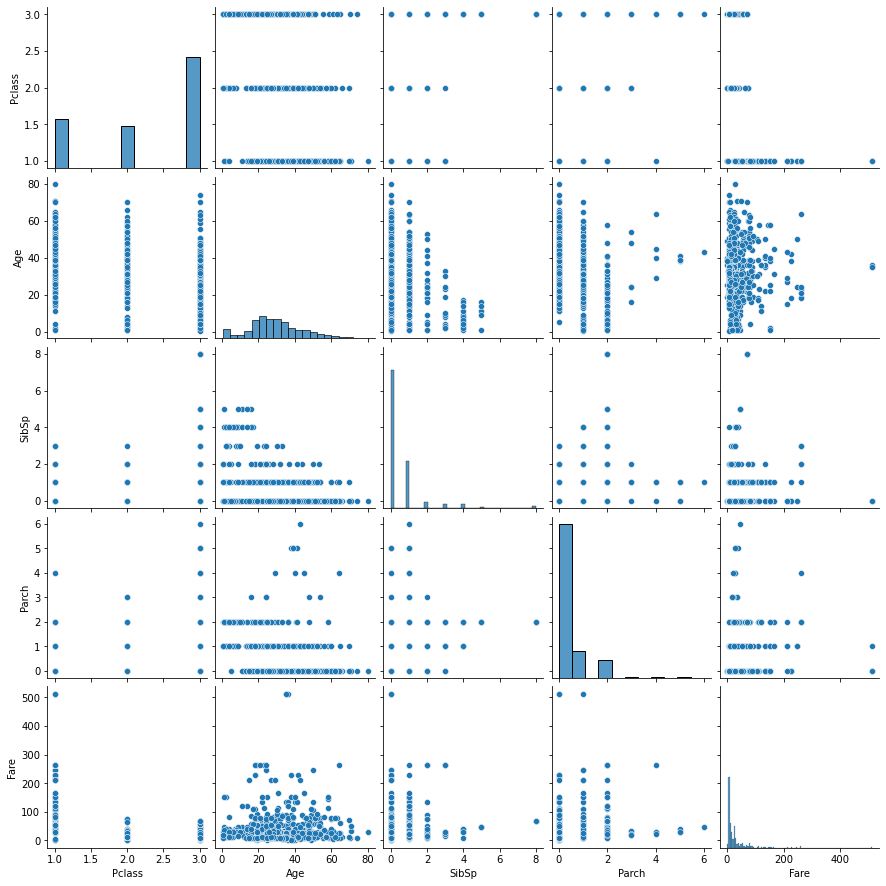

In [8]:
sns.pairplot(X_train)

In [9]:
X_train.describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [10]:
for column in X_train.columns:
    print(X_train[column].value_counts())

3    491
1    216
2    184
Name: Pclass, dtype: int64
male      577
female    314
Name: Sex, dtype: int64
24.00    30
22.00    27
18.00    26
19.00    25
30.00    25
         ..
55.50     1
70.50     1
66.00     1
23.50     1
0.42      1
Name: Age, Length: 88, dtype: int64
0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64
0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64
8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [11]:
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
# Seems all data matched as described
numeric = ["Pclass","Age","SibSp","Parch","Fare"]
category = ["Sex","Embarked"]

In [12]:
# It seems I dont need to drop my previous columns manually

numeric_transform = Pipeline(steps=[
    ("median_imputer", SimpleImputer(strategy="median")),
    ("minmax_scale", MinMaxScaler())
])

category_transform = Pipeline(steps=[
    ("mode_imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(drop="first"))
])


column_transform = ColumnTransformer([
    ("min_max_numerics", numeric_transform, numeric),
    ("one_hot_categories", category_transform,category)], remainder="drop")

In [13]:
# Since we have drop first, the actual category that will have extra values is Embarked(3 unqiue)
numeric + category

['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'Sex', 'Embarked']

In [14]:
X_train_processed = column_transform.fit_transform(X_train)
X_test_processed= column_transform.transform(X_test)
pd.DataFrame(X_train_processed).head()

,0,1,2,3,4,5,6,7
0,1.0,0.271174,0.125,0.0,0.014151,1.0,0.0,1.0
1,0.0,0.472229,0.125,0.0,0.139136,0.0,0.0,0.0
2,1.0,0.321438,0.000,0.0,0.015469,0.0,0.0,1.0
3,0.0,0.434531,0.125,0.0,0.103644,0.0,0.0,1.0
4,1.0,0.434531,0.000,0.0,0.015713,1.0,0.0,1.0


# LogisticRegression

In [15]:
LR = LogisticRegression(solver="liblinear")
LR.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [16]:
param_grid = {"penalty":["l1","l2"],
             "C":[0.1, 1.0, 10]}
# Accuracy should be enough for balanced binomial dataset...right?
best_LR = GridSearchCV(LR, param_grid,scoring="accuracy")
best_LR = best_LR.fit(X_train_processed, y_train)

print(best_LR.best_params_, best_LR.best_score_)
score = dict()
score["Logistic"] = best_LR.best_score_

{'C': 1.0, 'penalty': 'l2'} 0.7912434875400164


# DecisionTreeClassifier

In [17]:
# I know Tree models doesnt need scaling, but I need to fit other models
DTC = DecisionTreeClassifier(random_state=42)
param_grid = {"criterion": ["gini", "entropy"],
              "max_depth":[2,3,4,5]}


best_DTC = GridSearchCV(DTC, param_grid,scoring="accuracy")
best_DTC.fit(X_train_processed, y_train)

print(best_DTC.best_params_, best_DTC.best_score_)
score["DecisionTree"] = best_DTC.best_score_

{'criterion': 'entropy', 'max_depth': 3} 0.8148076078086749


# RandomForestClassifier

In [18]:
RFC = RandomForestClassifier(warm_start=True, n_jobs=-1)
param_grid = {"n_estimators":[50,60,70,80,90,100],
              "criterion": ["gini", "entropy"],
              "max_depth":[1,2,3]}


best_RFC = GridSearchCV(RFC, param_grid,scoring="accuracy")
best_RFC.fit(X_train_processed, y_train)

print(best_RFC.best_params_, best_RFC.best_score_)
score["RandomForest"] = best_RFC.best_score_

{'criterion': 'entropy', 'max_depth': 3, 'n_estimators': 100} 0.819295712761283


# SupportVectorMachine

In [19]:
SVM = SVC(random_state=42, max_iter=100000)
param_grid = {"C": [0.1, 1, 10, 15],
              "kernel": ["linear","rbf"]}


best_SVC = GridSearchCV(SVM, param_grid,scoring="accuracy")
best_SVC.fit(X_train_processed, y_train)

print(best_SVC.best_params_, best_SVC.best_score_)
score["SupportVector"] = best_SVC.best_score_

{'C': 10, 'kernel': 'rbf'} 0.8237963718536188


In [20]:
best_SVC.best_estimator_

SVC(C=10, max_iter=100000, random_state=42)

# GradientBoostingClassifier

In [21]:
GBC = GradientBoostingClassifier(warm_start=True, random_state=42)
param_grid = {"learning_rate":[0.1, 0.2, 0.3,0.4],
              "n_estimators": [70,80,90,100,200,300],
             "subsample": [0.5,0.8,1.0],
             "max_depth":[1,2,3,4]}


best_GBC = GridSearchCV(GBC, param_grid,scoring="accuracy")
best_GBC.fit(X_train_processed, y_train)

# save for submission
y_pred = best_GBC.predict(X_test_processed)
best_GBC_Submission = pd.DataFrame({"PassengerId" : test_data["PassengerId"], "Survived" : y_pred}).set_index("PassengerId")

print(best_GBC.best_params_, best_GBC.best_score_)
score["GradientBoosting"] = best_GBC.best_score_

{'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 90, 'subsample': 0.8} 0.8417738999435065


# Whats Next?

I woluld like to revisit this attempt after I'm done with the rest of the courses.
Though the main reason why I stopped here is because I couldnt get my voting and stacking classifiers to work as intended.
It seems compare to what the course are that are models should be fitted first, sklearn expecting none-fitted model at the moment. I made my attempt to run the following eitherway, somehow it just perform worse.
Please kindly suggest me if you know whats causeing this. Thanks!


In [22]:
estimators = [("Lr",best_LR.best_estimator_),
              ("DTC", best_DTC.best_estimator_),
              ("RFC", best_RFC.best_estimator_),
              ("SVC", best_SVC.best_estimator_),
              ("GBC", best_GBC.best_estimator_)]

SC = StackingClassifier(estimators=estimators, n_jobs=-1)
param_grid = {"passthrough":[True, False]}

best_SC = GridSearchCV(SC, param_grid, scoring="accuracy")
best_SC.fit(X_train_processed, y_train)

# save for submission
y_pred = best_SC.predict(X_test_processed)
best_SC_Submission = pd.DataFrame({"PassengerId" : test_data["PassengerId"], "Survived" : y_pred}).set_index("PassengerId")

print(best_SC.best_params_, best_SC.best_score_)
score["Stacking"] = best_SC.best_score_

{'passthrough': False} 0.8294143493817087


In [23]:
VC = VotingClassifier(estimators=estimators, voting="hard", n_jobs=-1)

#best_VC = GridSearchCV(VC, param_grid, scoring="accuracy")
VC.fit(X_train_processed, y_train)

# save for submission
y_pred = VC.predict(X_test_processed)
VC_Submission = pd.DataFrame({"PassengerId" : test_data["PassengerId"], "Survived" : y_pred}).set_index("PassengerId")

In [24]:
score

{'Logistic': 0.7912434875400164,
 'DecisionTree': 0.8148076078086749,
 'RandomForest': 0.819295712761283,
 'SupportVector': 0.8237963718536188,
 'GradientBoosting': 0.8417738999435065,
 'Stacking': 0.8294143493817087}

In [25]:
best_GBC_Submission.to_csv("best_GBC_Submission.csv")
best_SC_Submission.to_csv("best_SC_Submission.csv")
VC_Submission.to_csv("VC_Submission.csv")


ahahaha for some reason both gradient boost and stacking receive a public score of 0.77272
while boting some how receive 0.775.
I know they dont represent accuracy score, but this is still sad ahhaha

In [31]:
(best_SC_Submission == best_GBC_Submission).value_counts()

Survived
True        404
False        14
dtype: int64